# Deep Learning Model for Detecting COVID-19 using Chest X-Ray images
Image classification of Chest X Rays in one of three classes: Normal, Viral Pneumonia, COVID-19

Dataset taken from [COVID-19 Radiography Dataset](https://www.kaggle.com/tawsifurrahman/covid19-radiography-database) on Kaggle

# Importing required Libraries:

In [1]:
%matplotlib inline

import os
import shutil 
''' shutil used for moving images in test directory while forming the test set '''
import random
import torch
import torchvision
import numpy as np

from PIL import Image
from matplotlib import pyplot as plt

torch.manual_seed(0)

print('PyTorch version:', torch.__version__)

PyTorch version: 1.7.1


# Preparing Training and Test Sets:
Here, test directory is created and 30 randomly selected images per category are moved in it for the purpose of test dataset creation

In [2]:
class_names = ['normal', 'viral', 'covid']
# root_dir = 'COVID-19 Radiography Database'
root_dir = 'C:/Users/sweet/OneDrive/Desktop/ResearchPaperz/PROJECT/COVID-19 Radiography Database'
source_dirs = ['NORMAL', 'Viral Pneumonia', 'COVID-19']

if os.path.isdir(os.path.join(root_dir, source_dirs[1])):
    os.mkdir(os.path.join(root_dir, 'test'))

    for i, d in enumerate(source_dirs):
        os.rename(os.path.join(root_dir, d), os.path.join(root_dir, class_names[i]))

    for c in class_names:
        os.mkdir(os.path.join(root_dir, 'test', c))

    for c in class_names:
        images = [x for x in os.listdir(os.path.join(root_dir, c)) if x.lower().endswith('png')]
        selected_images = random.sample(images, 30)
        for image in selected_images:
            source_path = os.path.join(root_dir, c, image)
            target_path = os.path.join(root_dir, 'test', c, image)
            shutil.move(source_path, target_path)

# Creating Custom Dataset:
Here, Custom Dataset Class is created to help iterate through the dataset. This custom class inherits an abstract class Dataset
and overrides the two important methods:
<ul>
 <li><b> _len__ </b> so that len(dataset) returns the size of the dataset.</li>
<li><b> __getitem__ </b> to support the indexing such that dataset[i] can be used to get the ith sample</li></ul>

Our dataset will take an optional argument transform so that any required processing can be applied to the sample.

In [3]:
class ImgDataset(torch.utils.data.Dataset):
    def __init__(self, image_dirs, transform):
        def get_images(class_name):
            images = [x for x in os.listdir(image_dirs[class_name]) if x.lower().endswith('png')]
            print(f'Found {len(images)} {class_name} examples')
            return images
        self.images = {}
        self.class_names = ['normal', 'viral', 'covid']
        for class_name in self.class_names:
            self.images[class_name] = get_images(class_name)  
        self.image_dirs = image_dirs
        self.transform = transform
        
    
    def __len__(self):
        return sum([len(self.images[class_name]) for class_name in self.class_names])
    
    
    def __getitem__(self, index):
        class_name = random.choice(self.class_names)
        index = index % len(self.images[class_name])
        image_name = self.images[class_name][index]
        image_path = os.path.join(self.image_dirs[class_name], image_name)
        image = Image.open(image_path).convert('RGB')
        return self.transform(image), self.class_names.index(class_name)

# Image Transformations:

Most neural networks expect the images of a fixed size. Therefore, we perform some preprocessing over the train and test datasets. The second reason for image transformations is <b>data augmentation</b>.

Data augmentation is an approach that aids in increasing the variety of data for training models thus increasing the breadth of available information.The augmented data thus represents a more comprehensive set of possible data points. It improves the performance and ability of the model to generalize, hence, addressing overfitting.
The torchvision module of PyTorch provides transforms to accord common image transformations. These transformations can be chained together using <b>Compose</b>.

<ul><li><b>transforms.ToTensor</b> — Applies a scaling operation of changing range from 0–255 to 0–1. It converts a PIL Image or numpy ndarray to a tensor (C x H x W) in the range of 0–1.</li>
<li><b>transforms.Normalize</b>- This operation normalizes a tensor image with provided mean and standard deviation. For an image with 3 channels (RGB), 3 values for mean and 3 values for standard deviation are given as parameters(in form of tuple) corresponding to each channel. Normalization can help the CNN model to easily convert to global minimum or quickly reduce the loss.</li>
<li><b>transforms.RandomHorizontalFlip</b> — RandomHorizontalFlip changes the orientation horizontally. It flips the image randomly with a given probability (p). This is done only for the train set as we require this sort of data augmentation while training.</li>
<li><b>transforms.Resize —</b>To resize image this transformation can be used. It is also very useful incase of images with large dimensions to reduce it to a particular size (parameter for desired output size).</li>


In [4]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Preparing DataLoader:
Here, the transformed image data is loaded in the respective directories and the exact number of samples in each category of data is displayed with the help of class ImgDataset created earlier.

To achieve this, we create a dictionary with the keys as the different class names(normal, viral, and COVID), and the values to each key would be their corresponding directory in which the images of that class are stored. After that, we create 2 objects of the custom dataset class by passing the train and test dictionaries with their respective transform as parameters.

In [5]:
train_dirs = {
    'normal': f'{root_dir}/normal',
    'viral': f'{root_dir}/viral',
    'covid': f'{root_dir}/covid'
}

train_dataset = ImgDataset(train_dirs, train_transform)

Found 1311 normal examples
Found 1315 viral examples
Found 1113 covid examples


In [6]:
test_dirs = {
    'normal': f'{root_dir}/test/normal',
    'viral': f'{root_dir}/test/viral',
    'covid': f'{root_dir}/test/covid'
}

test_dataset = ImgDataset(test_dirs, test_transform)

Found 30 normal examples
Found 30 viral examples
Found 30 covid examples


<br><br>
Now, we need to pass the objects created in the previous step, to the dataloader with certain batch size. The batch size basically is the number of samples that will be passed through  the network at one time.
The purpose of the dataloader is to allow an easier implementation of chunk-reading and dynamic batch size (e.g., by yielding a batched sample at each time).

In [7]:
batch_size = 6

dl_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dl_test = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

print('Number of training batches', len(dl_train))
print('Number of test batches', len(dl_test))

Number of training batches 624
Number of test batches 15


# Data Visualization:

Here, a function show_imgs is defined that would take the true labels, the predicted labels, and a set of images passed through a dataloader iterator and display a set of images and if the prediction is correct. That is to say, if the predicted label of the image matches with the true label of the image, then the predicted label would be displayed on the side of the image in green color and if the prediction is wrong, the predicted label would be displayed in red color. <br>
Since we have not trained our model yet, we are going to pass the true labels as the predicted labels for now.

In [8]:
class_names = train_dataset.class_names


def show_imgs(images, labels, preds):
    plt.figure(figsize=(8, 4))
    for i, image in enumerate(images):
        plt.subplot(1, 6, i + 1, xticks=[], yticks=[])
        image = image.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image * std + mean
        image = np.clip(image, 0., 1.)
        plt.imshow(image)
        col = 'green'
        if preds[i] != labels[i]:
            col = 'red'
            
        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color=col)
    plt.tight_layout()
    plt.show()

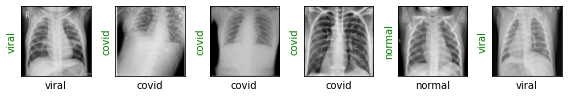

In [9]:
images, labels = next(iter(dl_train))
show_imgs(images, labels, labels)

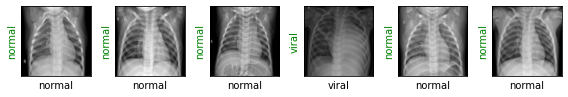

In [10]:
images, labels = next(iter(dl_test))
show_imgs(images, labels, labels)

# Creating the Model using Transfer Learning:


Transfer learning is the improvement of learning in a new task through the transfer of knowledge from a related task that has already been learned. <br><br>
This approach is effective because the images were trained on a large corpus of photographs and require the model to make predictions on a relatively large number of classes, in turn, requiring that the model efficiently learn to extract features from photographs in order to perform well on the problem.

The first name that came across my mind was <b>ResNet-18</b>, a well-known convolutional neural network that is 18 layers deep. One can load a pretrained version of the network trained on more than a million images from the ImageNet database (1.2 million images). The pretrained network can classify images into 1000 object categories and as a result, the network has learned rich feature representations for a wide range of images.

<br> The below code shows getting a pre-trained model of ResNet-18 and then prints its architecture

In [11]:
resnet18 = torchvision.models.resnet18(pretrained=True)

print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Now, we modify the last FC layer of the pre-trained model that has 512 input features and 1000 output features as the number of classes on which ResNet was trained was 1000. But, in our case, it is just 3.
<br><br>Then, we assign a CrossEntropy Loss to the model as it was the obvious choice for a classification task and use Adam as the optimizer with a learning rate of 3e-5

In [12]:
resnet18.fc = torch.nn.Linear(in_features=512, out_features=3)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.parameters(), lr=3e-5)

Now, we create another function that would make predictions during the training by iterating the dataloader and passing a batch of images to the modified ResNet model for prediction, and then display the results using the show_imgs() function that we previously created.

In [13]:
def show_preds():
    resnet18.eval()
    images, labels = next(iter(dl_test))
    outputs = resnet18(images)
    _, preds = torch.max(outputs, 1)
    show_imgs(images, labels, preds)

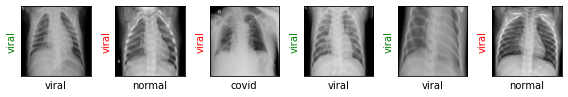

In [14]:
show_preds()

# Training the Model:
Now, we create another function for the final part i.e the training of the model. Here, we simply have to loop over our data iterator, feed the inputs to the network and optimize.

In [15]:
def train(epochs):
    print('Starting training..')
    for e in range(0, epochs):
        print('='*20)
        print(f'Starting epoch {e + 1}/{epochs}')
        print('='*20)

        train_loss = 0.
        val_loss = 0.

        resnet18.train() # set model to training phase

        for train_step, (images, labels) in enumerate(dl_train):
            optimizer.zero_grad()
            outputs = resnet18(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            if train_step % 20 == 0:
                print('Evaluating at step', train_step)

                accuracy = 0

                resnet18.eval() # set model to eval phase

                for val_step, (images, labels) in enumerate(dl_test):
                    outputs = resnet18(images)
                    loss = loss_fn(outputs, labels)
                    val_loss += loss.item()

                    _, preds = torch.max(outputs, 1)
                    accuracy += sum((preds == labels).numpy())

                val_loss /= (val_step + 1)
                accuracy = accuracy/len(test_dataset)
                print(f'Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')

                show_preds()

                resnet18.train() #set model to training phase

                if accuracy >= 0.95:
                    print('Performance condition satisfied, stopping..')
                    return

        train_loss /= (train_step + 1)

        print(f'Training Loss: {train_loss:.4f}')
    print('Training complete..')

Starting training..
Starting epoch 1/1
Evaluating at step 0
Validation Loss: 1.2237, Accuracy: 0.3333


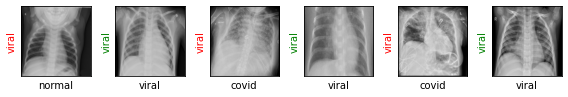

Evaluating at step 20
Validation Loss: 0.7381, Accuracy: 0.7333


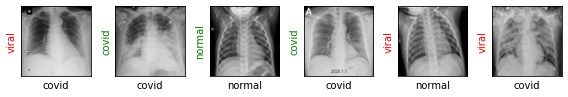

Evaluating at step 40
Validation Loss: 0.2873, Accuracy: 0.9444


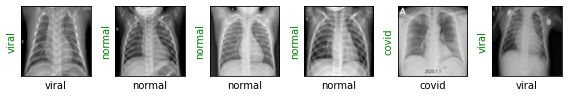

Evaluating at step 60
Validation Loss: 0.2274, Accuracy: 0.9222


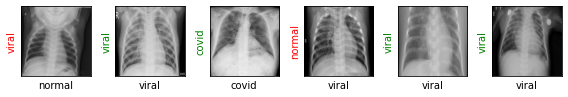

Evaluating at step 80
Validation Loss: 0.1548, Accuracy: 0.9222


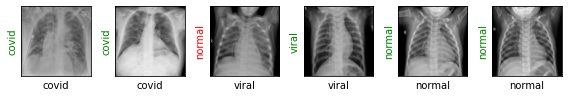

Evaluating at step 100
Validation Loss: 0.1467, Accuracy: 0.9444


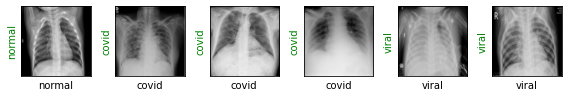

Evaluating at step 120
Validation Loss: 0.1116, Accuracy: 0.9556


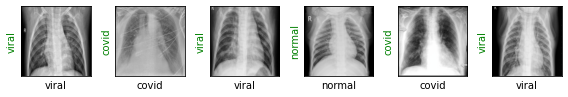

Performance condition satisfied, stopping..
Wall time: 4min 5s


In [16]:
%%time

train(epochs=1)

# Final Results:
Now that the training is complete, our model is ready to be saved and tested. We test it using a previously defined function - show_preds()

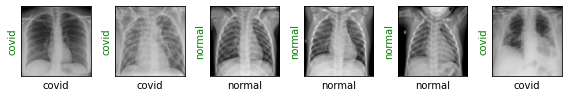

In [18]:
show_preds()

# Saving the Model

In [19]:
torch.save(resnet18.state_dict(), 'covid_classifier.pt')

# Inference on a Single Image: Predicting the class label
Till now, we have trained our model on different batches of images. Now, we test it on a single image input. 
<br>To do that, we need to first transform the input, the same way we transformed the testing images. After that, we load the weights of the saved model, change the mode to evaluation, and pass the image as an input to produce an output tensor. Then, using a dictionary mapping, we return the predicted label.

In [20]:
# Load the model and set in eval
resnet18 = torchvision.models.resnet18(pretrained=True)
resnet18.fc = torch.nn.Linear(in_features=512, out_features=3)

resnet18.load_state_dict(torch.load('covid_classifier.pt'))
resnet18.eval()


def predict_image_class(image_path):
    image = Image.open(image_path).convert('RGB')
    image = test_transform(image)
    # test_transform() is defined already in a previous code cell
    image = image.unsqueeze(0)
    output = resnet18(image)[0]
    probabilities = torch.nn.Softmax(dim=0)(output)
    probabilities = probabilities.cpu().detach().numpy()
    predicted_class_index = np.argmax(probabilities)
    predicted_class_name = class_names[predicted_class_index]
    return probabilities, predicted_class_index, predicted_class_name

In [22]:
image_path = 'C:/Users/sweet/OneDrive/Desktop/ResearchPaperz/PROJECT/COVID-19 Radiography Database/test/covid/COVID-19 (136).png'

probabilities, predicted_class_index, predicted_class_name = predict_image_class(image_path)
print('Probabilities:', probabilities)
print('Predicted class index:', predicted_class_index)
print('Predicted class name:', predicted_class_name)

Probabilities: [0.01526446 0.00680313 0.9779324 ]
Predicted class index: 2
Predicted class name: covid
